# Pythonによるマーケティングミックスモデリング （MMM：Marketing Mix Modeling）超入門 その1 線形回帰モデルでMMMを作ろう！

url: https://www.salesanalytics.co.jp/datascience/datascience097/

url: https://www.salesanalytics.co.jp/mmm-intro/

    本当に売上に貢献している広告は、どの広告か？

    売上と広告媒体等との関係性をモデリングし、どの広告媒体が売上にどれほど貢献していたのか分析することができます。

    それが、マーケティングミックスモデリング（MMM：Marketing Mix Modeling）です。

    マーケティングミックスモデリング（MMM：Marketing Mix Modeling）は、単に今までどうだったのかを分析するだけでなく、今後どうなりそうかという近未来分析をすることもできます。

    マーケティングミックスモデリング（MMM：Marketing Mix Modeling）で扱うデータは時系列データです。

    このような時系列データに対し、時系列系の数理モデルを構築するのもいいですが、線形回帰モデルのような、シンプルなテーブルデータ系の数理モデルでも構築できます。

    今回は、「線形回帰モデルでMMMを作ろう！」というお話しをします。

## 利用するデータセット
    今回利用するデータセットの変数です。

    Week：週
    Sales：売上
    TVCM：TV CMのコスト
    Newspaper：新聞の折り込みチラシのコスト
    Web：Web広告のコスト

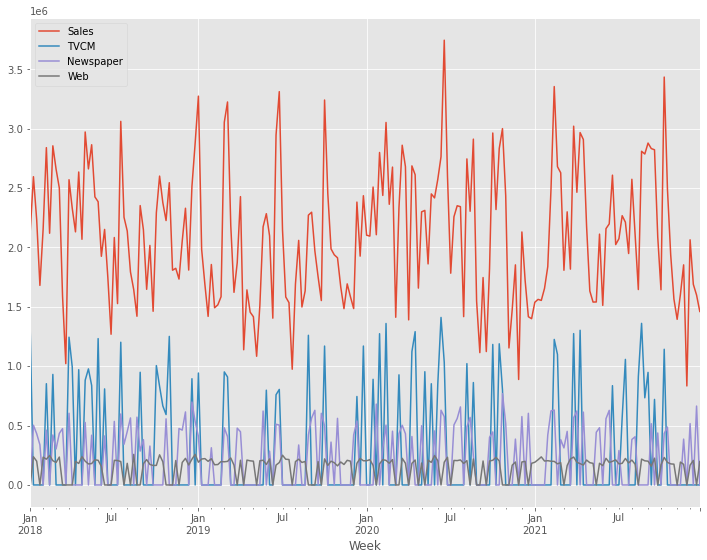

    以下からダウンロードできます。

    MMM.csv
    https://www.salesanalytics.co.jp/4zdt

## ３つの成果物
    マーケティングミックスモデリング（MMM：Marketing Mix Modeling）の、主な3つの成果物です。

    ・売上貢献度
    ・ROI=（売上貢献度－コスト）÷コスト
    ・予測モデル
    先ず、どの広告媒体が、どれだけ売上に貢献したのかを見える化できます。



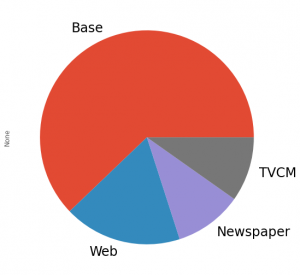

    Baseは、広告などに依存しない売上高です。市場に浸透している商品ほどBaseの割合が大きくなります。

    広告媒体のコストデータがあれば、ROIを見える化できます。

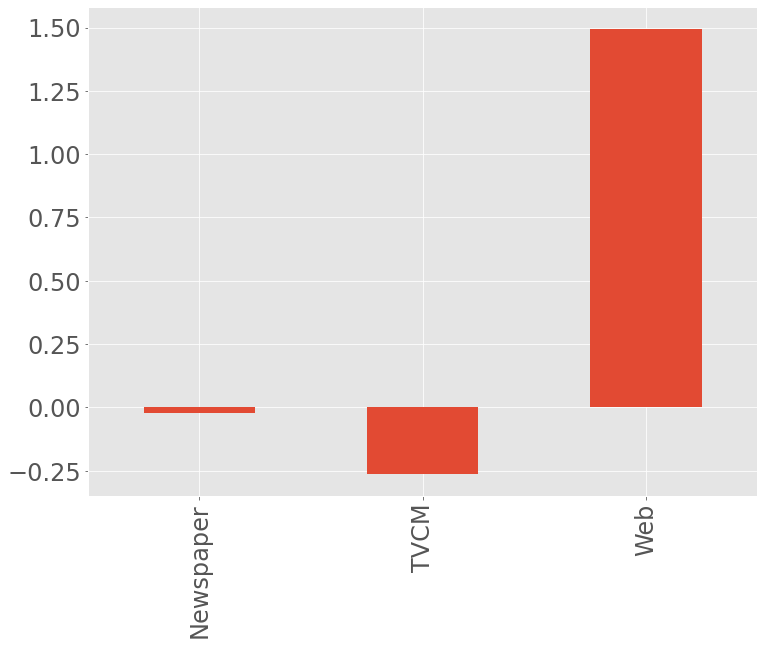

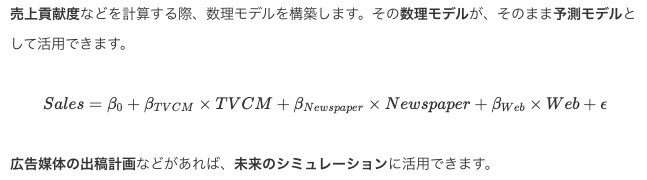

## 流れ
    流れについて簡単に説明します。

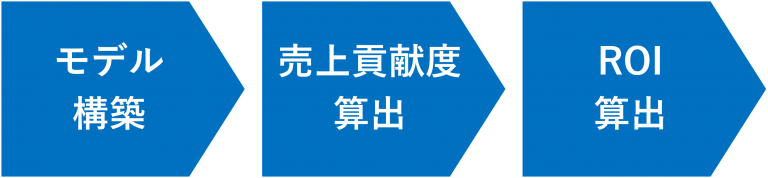

    先ず、売上であるSalesを目的変数に、TVCMとNewspaper、Webのコストを説明変数に、線形回帰モデルを構築します。

    次に、構築した線形回帰モデルを使い、媒体別の売上貢献度を求めます。

    売上貢献度を足し合わせると売上の予測値になりますが、通常の予測値は実測値と乖離します。予測値を実測値に合わせるための補正係数を計算し、補正済み売上貢献度を計算します。

    最後に、売上貢献度（補正済み）を使い、媒体別のROIを計算します。

## MMMの実施
### ライブラリーの読み込み
    先ず、必要なライブラリーなどを読み込みます。

    以下、コードです。

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ

#指数表記しない設定
np.set_printoptions(precision=3,suppress=True)
pd.options.display.float_format = '{:.3f}'.format

## データセットの読み込み
    データセットを読み込みます。

    以下、コードです。

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2018-01-07 to 2021-12-26
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sales      208 non-null    int64
 1   TVCM       208 non-null    int64
 2   Newspaper  208 non-null    int64
 3   Web        208 non-null    int64
dtypes: int64(4)
memory usage: 8.1 KB
None


,Sales,TVCM,Newspaper,Web
Week,,,,
2018-01-07,2132000,1312200,0,0
2018-01-14,2596100,0,502900,237400
2018-01-21,2236200,0,432100,200600
2018-01-28,1680900,0,338400,0
2018-02-04,2155400,0,0,234000


<Axes: xlabel='Week'>

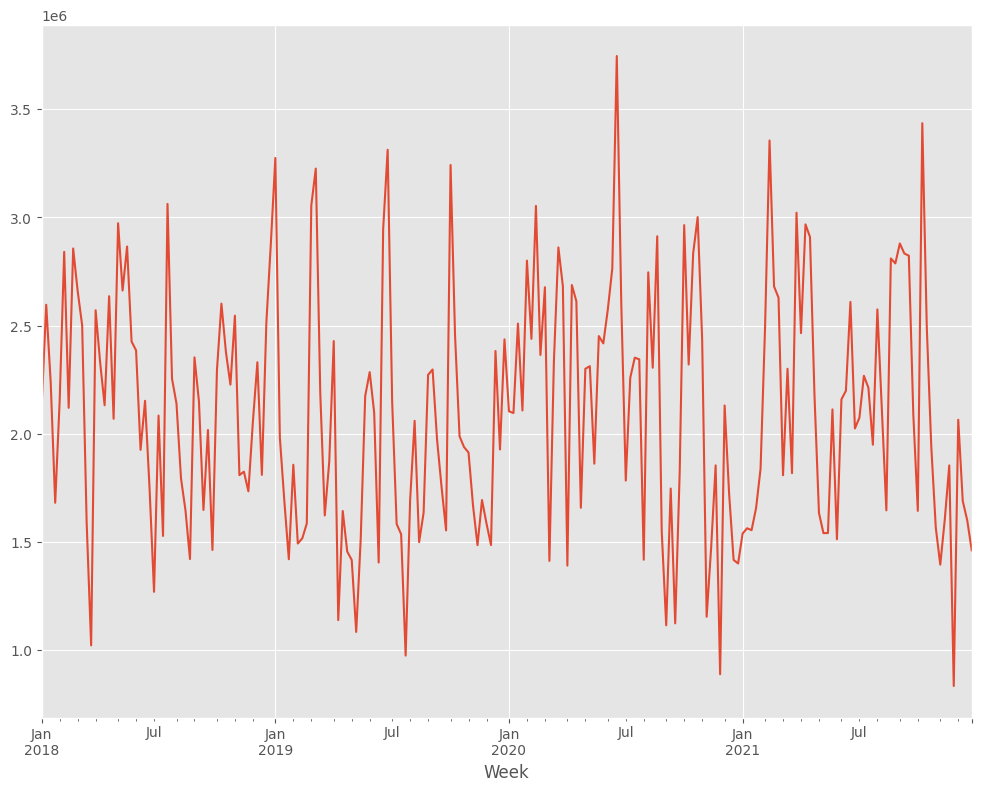

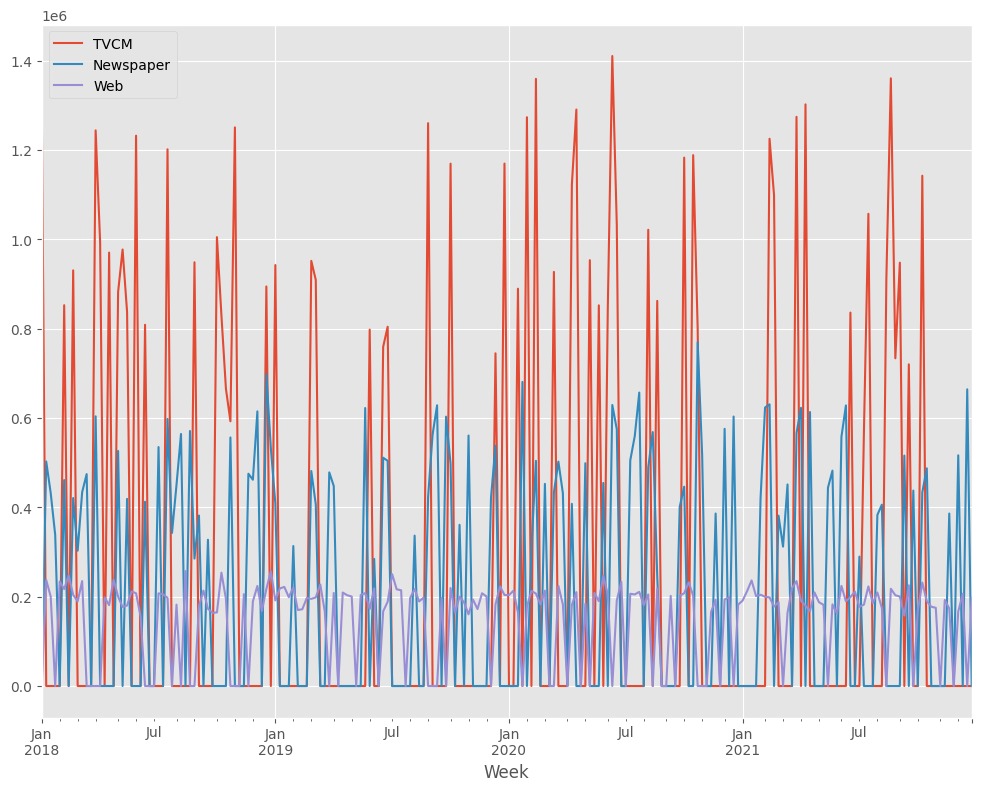

In [2]:
# データセット読み込み
url = 'https://www.salesanalytics.co.jp/4zdt'
df = pd.read_csv(url,
                 parse_dates=['Week'],
                 index_col='Week'
                )

# データ確認
print(df.info()) #変数の情報
display(df.head()) #データの一部

# 説明変数Xと目的変数yに分解
X = df.drop(columns=['Sales'])
y = df['Sales']

# グラフ化
y.plot()
X.plot()

## モデル構築
    線形回帰モデルを構築します。

    先ず、線形回帰モデルのインスタンスを作ります。

    以下、コードです。

In [3]:
# 線形回帰モデルのインスタンス
lr = LinearRegression()

    線形回帰モデルが、どの程度の予測精度を持ったモデルになるのかを確かめるために、
    時系列のCV（クロスバリデーション）を実施します。今回は、デフォルトの5分割のCVです。

    以下、コードです。

In [4]:
# クロスバリデーションで精度検証
np.mean(cross_val_score(lr,
                        X, y,
                        cv=TimeSeriesSplit()
                       )
       )

# この実行結果は、5分割CVの結果（決定係数R**2）の平均値です。悪くはないですが、ものすごくいいわけでもありません。

0.7027465640779165

    推薦アルゴリズムとしてSVDを使います。ハイパーパラメータがいくつかありますので、チューニングします。

    以下、コードです。

    では、全てのデータを使い線形回帰モデルを構築します。

    以下、コードです。

In [5]:
# 線形回帰モデルの学習
lr.fit(X, y)

# 回帰係数をデータフレーム化
weights = pd.Series(
    lr.coef_,
    index=X.columns
)

# 結果出力（切片と係数）
print('Intercept:\n', lr.intercept_, sep='')
print()
print('Coefficients:\n',weights, sep='')

Intercept:
1311157.944523329

Coefficients:
TVCM        0.735
Newspaper   0.975
Web         2.497
dtype: float64


## 売上貢献度の算出
    先程求めた線形回帰式を使い、売上貢献度（補正前）を計算します。

    以下、コードです。

In [6]:
# 貢献度（補正前）
unadj_contribution = X.mul(weights) #Xと係数を乗算
unadj_contribution = unadj_contribution.assign(Base=lr.intercept_) #切片の追加
unadj_contribution.head() #確認

,TVCM,Newspaper,Web,Base
Week,,,,
2018-01-07,964842.522,0.000,0.000,1311157.945
2018-01-14,0.000,490351.393,592880.267,1311157.945
2018-01-21,0.000,421318.029,500976.333,1311157.945
2018-01-28,0.000,329956.077,0.000,1311157.945
2018-02-04,0.000,0.000,584389.142,1311157.945


    週ごとに各媒体の売上貢献度を合計すると、売上の予測値になります。

    以下、コードです。

In [7]:
# 貢献度の合計（yの予測値）
y_pred = unadj_contribution.sum(axis=1)
y_pred.head() #確認

Week
2018-01-07   2276000.466
2018-01-14   2394389.604
2018-01-21   2233452.307
2018-01-28   1641114.022
2018-02-04   1895547.087
dtype: float64

    元の売上の実測値を見てみます。

    以下、コードです。

In [8]:
y.head() #確認

Week
2018-01-07    2132000
2018-01-14    2596100
2018-01-21    2236200
2018-01-28    1680900
2018-02-04    2155400
Name: Sales, dtype: int64

    予測値と実測値が乖離していることが分かります。この乖離をなくすために、補正係数（correction factor）を計算し、売上貢献度を補正します。

    補正係数を計算します。

    以下、コードです。

In [9]:
# 補正係数
correction_factor = y.div(y_pred, axis=0)

correction_factor.head() #確認

Week
2018-01-07   0.937
2018-01-14   1.084
2018-01-21   1.001
2018-01-28   1.024
2018-02-04   1.137
dtype: float64

    この補正係数を使い、売上貢献度を補正します。

    以下、コードです。

In [10]:
# 貢献度（補正後）
adj_contribution = (unadj_contribution
                    .mul(correction_factor, axis=0)
                   )

# 順番の変更
adj_contribution = adj_contribution[['Base', 'Web', 'Newspaper', 'TVCM']]

#確認
adj_contribution.head()

,Base,Web,Newspaper,TVCM
Week,,,,
2018-01-07,1228202.181,0.000,0.000,903797.819
2018-01-14,1421613.732,642826.237,531660.031,0.000
2018-01-21,1312770.990,501592.657,421836.353,0.000
2018-01-28,1342944.707,0.000,337955.293,0.000
2018-02-04,1490899.305,664500.695,0.000,0.000


    週×媒体別の売上貢献度が求められたので、積み上げグラフを作成し、どのような状況になっているのかを確認してみます。

    以下、コードです。

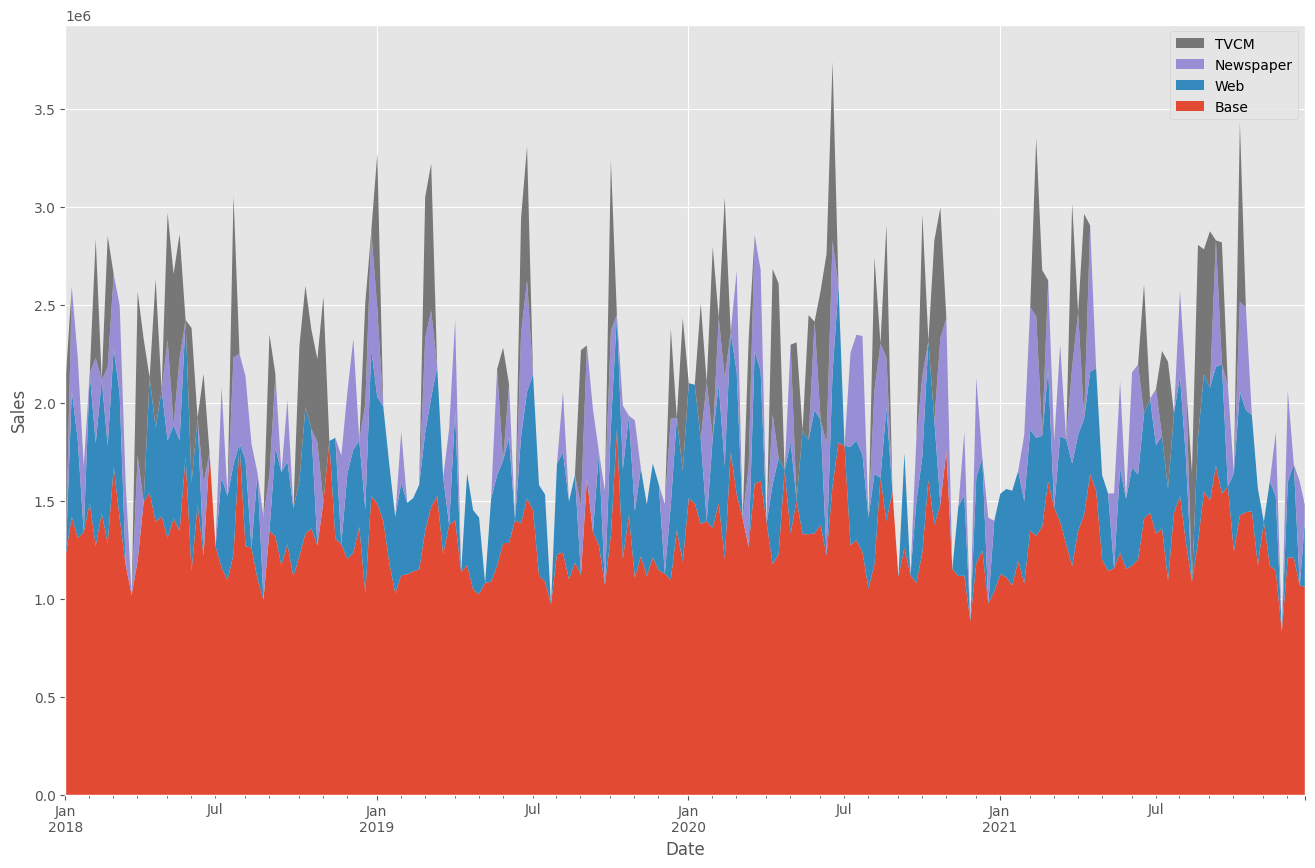

In [11]:
# グラフ化
ax = (adj_contribution
      .plot.area(
          figsize=(16, 10),
          linewidth=0,
          ylabel='Sales',
          xlabel='Date')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

    媒体別に全ての週の売上貢献度を合計し、媒体別の売上貢献度（円と構成比％）と、そのグラフを作り、何がどれほど売上に貢献したのかを見てみます。

    以下、コードです。

売上貢献度（円）:
Base        272553878.372
Web          78134505.301
Newspaper    44967187.251
TVCM         42900529.075
dtype: float64

売上貢献度（構成比）:
Base        0.621
Web         0.178
Newspaper   0.103
TVCM        0.098
dtype: float64


<Axes: >

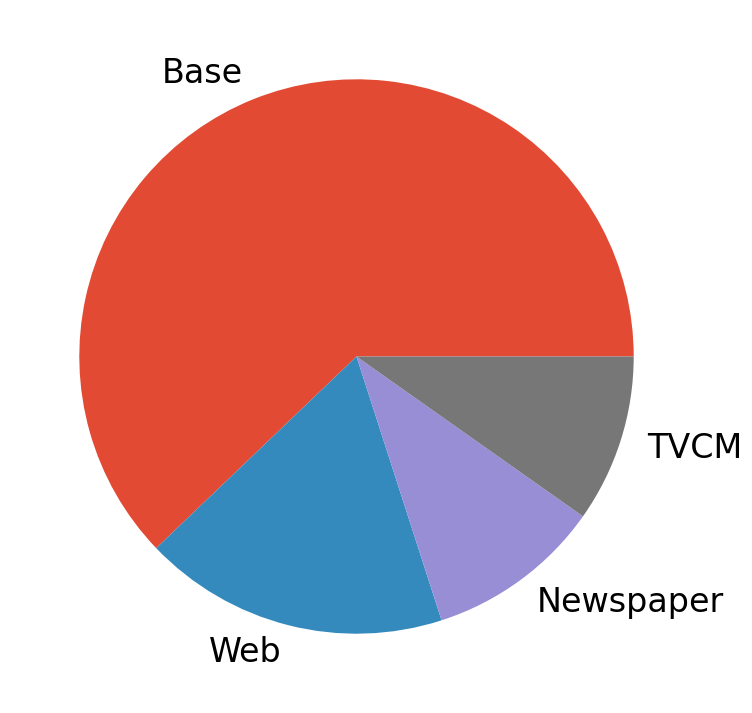

In [12]:
# 媒体別の貢献度の合計
contribution_sum = adj_contribution.sum(axis=0)

#集計結果
print('売上貢献度（円）:\n',
      contribution_sum,
      sep=''
     )

print()

print('売上貢献度（構成比）:\n',
      contribution_sum/contribution_sum.sum(),
      sep=''
     )

#グラフ化
contribution_sum.plot.pie(fontsize=24)

外部ファイル（’new_user_recommendations.csv’）として、新規ユーザに対するレコメンドを保存しています。

    費用対効果を見てみます。今回は媒体別にROIを計算します。

    先ず、媒体別のコストを集計します。

    以下、コードです。



In [13]:
# 各媒体のコストの合計
cost_sum = X.sum(axis=0)
cost_sum #確認

TVCM         58147500
Newspaper    45986200
Web          31329300
dtype: int64

    先程求めた売上貢献度を使い、媒体別のROIを計算しグラフ化します。

    以下、コードです。

ROI:
Newspaper   -0.022
TVCM        -0.262
Web          1.494
dtype: float64


<Axes: >

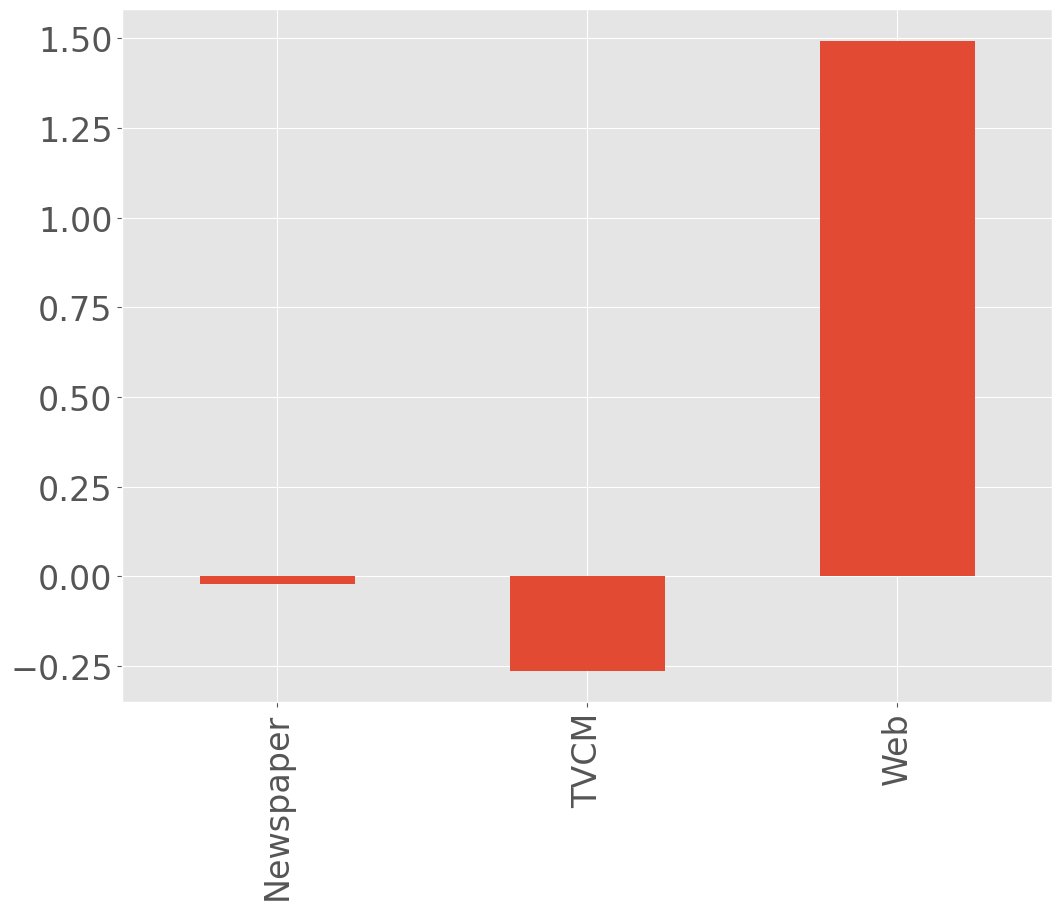

In [14]:
# 各媒体のROIの計算
ROI = (contribution_sum.drop('Base', axis=0) - cost_sum)/cost_sum

#確認
print('ROI:\n', ROI, sep='')

# グラフ化
ROI.plot.bar(fontsize=24)

# ROIは、値が大きいほど良く、最低限プラスの値である必要があります。Web広告以外はあまり良くないことが分かります。

    このモデルには、ある致命的な欠陥があります。アドストック（Ad Stock）を考慮していないということです。

    アドストック（Ad Stock）を考慮したモデルにした方がいいでしょう。

    ちなみに、アドストック（Ad Stock）を考慮するとは、残存効果を考慮するということです。
    ある日の広告宣伝活動が、その日だけに効果があるのではなく、次の日以降もその効果が続くということです。
    キャリーオーバー（Carryover）効果と表現されることもあります。

## 次回
    今回は、「線形回帰モデルでMMMを作ろう！」というお話しをしました。

    次回は、「アドストック（Ad Stock）を考慮した線形回帰モデル」というお話しをします。